In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import plotly as py
from plotly import tools
from plotly.offline import iplot
import matplotlib.pyplot as plt
from matplotlib import dates
import seaborn as sns
from math import sqrt
import statsmodels.api as sm
#from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools  import adfuller
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acovf, acf
from statsmodels.graphics.tsaplots import plot_acf
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/content/dataset'):

    for filename in filenames:
        print(os.path.join(dirname, filename))

#Graph Settings
plt.rcParams['figure.figsize'] = (15,4)
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 14

In [ ]:
#Importing Packages
!pip install pmdarima
from pmdarima import auto_arima

In [ ]:
#Loading Data
dt = pd.read_csv("dataset.csv", parse_dates=["created_at", "Working Date"], low_memory=False)

In [ ]:
#Basic EDA
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46447 entries, 0 to 46446
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   item_id                46447 non-null  int64         
 1   status                 46447 non-null  object        
 2   created_at             46447 non-null  datetime64[ns]
 3   sku                    46442 non-null  object        
 4   price                  46447 non-null  float64       
 5   qty_ordered            46447 non-null  int64         
 6   grand_total            46447 non-null  float64       
 7   increment_id           46447 non-null  int64         
 8   category_name_1        46447 non-null  object        
 9   sales_commission_code  46447 non-null  object        
 10  discount_amount        46447 non-null  float64       
 11  payment_method         46447 non-null  object        
 12  Working Date           46447 non-null  datetime64[ns]
 13  B

In [ ]:
print("Data Dimensions are: ", dt.shape)
print("Columns: ", dt.columns)

Data Dimensions are:  (46447, 26)
Columns:  Index(['item_id', 'status', 'created_at', 'sku', 'price', 'qty_ordered',
       'grand_total', 'increment_id', 'category_name_1',
       'sales_commission_code', 'discount_amount', 'payment_method',
       'Working Date', 'BI Status', ' MV ', 'Year', 'Month', 'Customer Since',
       'M-Y', 'FY', 'Customer ID', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23',
       'Unnamed: 24', 'Unnamed: 25'],
      dtype='object')


In [ ]:
dt.rename(columns = {' MV ':'MV'}, inplace = True)
#Droping Null Columns
dt = dt.iloc[:, :-5]
dt = dt.dropna(how = 'all')
dt.columns

Index(['item_id', 'status', 'created_at', 'sku', 'price', 'qty_ordered',
       'grand_total', 'increment_id', 'category_name_1',
       'sales_commission_code', 'discount_amount', 'payment_method',
       'Working Date', 'BI Status', 'MV', 'Year', 'Month', 'Customer Since',
       'M-Y', 'FY', 'Customer ID'],
      dtype='object')

In [ ]:
#Casting on Data types
dt['Customer ID'] = dt['Customer ID'].astype(str)
dt['item_id'] = dt['item_id'].astype(str)
dt['qty_ordered'] = dt['qty_ordered'].fillna(0).astype(int)
dt['Year'] = dt['Year'].fillna(0).astype(int)
dt['Month'] = dt['Month'].fillna(0).astype(int)

In [ ]:
#Data Summary
dt.describe()

,created_at,price,qty_ordered,grand_total,increment_id,discount_amount,Working Date,Year,Month
count,46447,46447.000000,46447.000000,4.644700e+04,4.644700e+04,46447.000000,46447,46447.0,46447.000000
mean,2016-09-04 06:50:32.566150656,4374.453903,1.150666,5.756756e+03,1.001670e+08,121.015672,2016-09-04 06:50:32.566150656,2016.0,8.600254
min,2016-07-01 00:00:00,0.000000,1.000000,0.000000e+00,1.001474e+08,0.000000,2016-07-01 00:00:00,2016.0,7.000000
25%,2016-08-06 00:00:00,270.000000,1.000000,3.250000e+02,1.001572e+08,0.000000,2016-08-06 00:00:00,2016.0,8.000000
50%,2016-09-10 00:00:00,570.000000,1.000000,8.320000e+02,1.001671e+08,0.000000,2016-09-10 00:00:00,2016.0,9.000000
75%,2016-09-30 00:00:00,1795.000000,1.000000,3.019000e+03,1.001770e+08,0.000000,2016-09-30 00:00:00,2016.0,9.000000
max,2016-10-25 00:00:00,235000.000000,130.000000,1.280473e+06,1.001866e+08,33750.000000,2016-10-25 00:00:00,2016.0,10.000000
std,NaN,11908.215336,1.480206,2.172460e+04,1.137905e+04,816.100463,NaN,0.0,1.038622


In [ ]:
dt = dt.sort_values('created_at')
#Adding New Features
dtg = dt.groupby('created_at')['grand_total'].sum().reset_index()
dtq = dt.groupby('created_at')['qty_ordered'].sum().reset_index()
dtd = dt.groupby('created_at')['discount_amount'].sum().reset_index()
#Comput count for non numeric values
dts = dt.groupby('created_at')['sku'].count().reset_index()
dtst = dt.groupby('created_at')['status'].count().reset_index()
# new data set
p = pd.DataFrame(dtg)
p['qty_ordered'] = dtq['qty_ordered']
p['discount_amount'] = dtd['discount_amount']
p['sku'] = dts['sku']
p['status'] = dtst['status']
#Cumulative Sum
p['cum_grand_total'] = p['grand_total'].cumsum()
p['cum_qty_ordered'] = p['qty_ordered'].cumsum()
p['cum_discount_amount'] = p['discount_amount'].cumsum()
p['cum_sku_cnt'] = p['sku'].cumsum()
p['cum_status_cnt'] = p['status'].cumsum()
# Date features
p['Dateofmonth'] = p['created_at'].dt.day
p['Month'] = p['created_at'].dt.month
p['Week'] = p['created_at'].dt.isocalendar().week
p['Dayofweek'] = p['created_at'].dt.dayofweek # 0 = monday.
p['Weekdayflg'] = (p['Dayofweek'] // 5 != 1).astype(float)
p['Month'] = p['created_at'].dt.month
p['Quarter'] = p['created_at'].dt.quarter
p['Dayofyear'] = p['created_at'].dt.dayofyear

In [ ]:
p.head()

,created_at,grand_total,qty_ordered,discount_amount,sku,status,cum_grand_total,cum_qty_ordered,cum_discount_amount,cum_sku_cnt,cum_status_cnt,Dateofmonth,Month,Week,Dayofweek,Weekdayflg,Quarter,Dayofyear
0,2016-07-01,1301026.75,621,8100.0,547,547,1301026.75,621,8100.0,547,547,1,7,26,4,1.0,3,183
1,2016-07-02,1408450.48,301,2502.0,260,260,2709477.23,922,10602.0,807,807,2,7,26,5,0.0,3,184
2,2016-07-03,2215490.88,264,1501.0,210,210,4924968.11,1186,12103.0,1017,1017,3,7,26,6,0.0,3,185
3,2016-07-04,1094080.25,263,4406.0,229,229,6019048.36,1449,16509.0,1246,1246,4,7,27,0,1.0,3,186
4,2016-07-05,913053.50,194,5230.0,168,168,6932101.86,1643,21739.0,1414,1414,5,7,27,1,1.0,3,187


In [ ]:
#selecting first two column
p = p.iloc[:, 0:2]
p.head()

,created_at,grand_total
0,2016-07-01,1301026.75
1,2016-07-02,1408450.48
2,2016-07-03,2215490.88
3,2016-07-04,1094080.25
4,2016-07-05,913053.50


In [ ]:
#Converting this column to datetime
p['created_at'] = pd.to_datetime(p['created_at'],format='%Y-%m-%d')

In [ ]:
#Accessing any specific date
p.loc[1, 'created_at'].day_name()
#We can also convert dates into days
p['created_at'].dt.day_name()

0        Friday
1      Saturday
2        Sunday
3        Monday
4       Tuesday
         ...   
112      Friday
113    Saturday
114      Sunday
115      Monday
116     Tuesday
Name: created_at, Length: 117, dtype: object

In [ ]:
p.head()

,created_at,grand_total
0,2016-07-01,1301026.75
1,2016-07-02,1408450.48
2,2016-07-03,2215490.88
3,2016-07-04,1094080.25
4,2016-07-05,913053.50


In [ ]:
#For Time Series,Date column must be in indexes
p = p.set_index('created_at')
from datetime import datetime
p.head()

,grand_total
created_at,
2016-07-01,1301026.75
2016-07-02,1408450.48
2016-07-03,2215490.88
2016-07-04,1094080.25
2016-07-05,913053.50


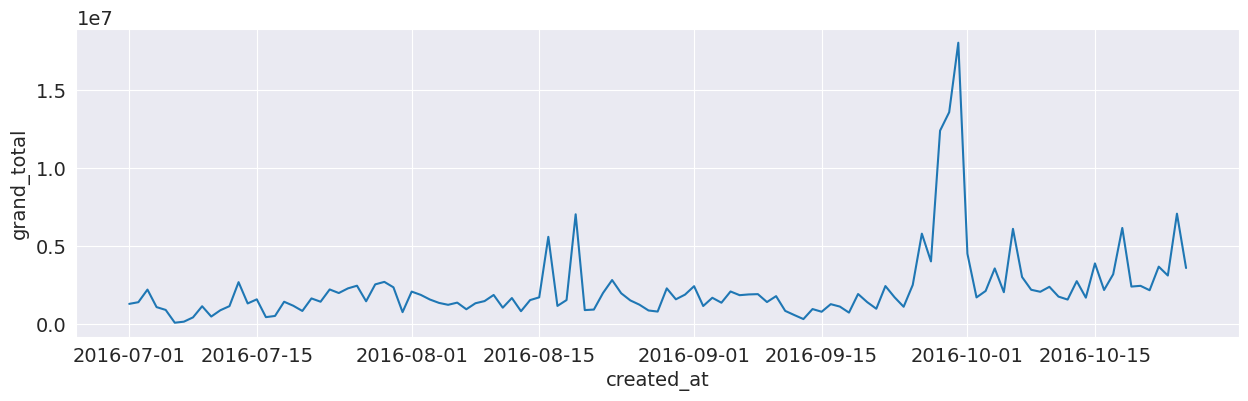

In [ ]:
#Plotting graph between year and Total sales
sns.lineplot(x = "created_at" , y = "grand_total",data= p )
plt.show()

In [ ]:
#Checking Dataset is stationary or not
results = adfuller(p['grand_total'])
print(results)

(-5.237894391551582, 7.353793359868218e-06, 0, 116, {'1%': -3.4880216384691867, '5%': -2.8867966864160075, '10%': -2.5802408234244947}, 3287.3228753587578)


In [ ]:
#We can also print p-value,Test statistics and Critical values as follows
results = adfuller(p['grand_total'])
print('Test Statistics: %f' % results[0])
print('p-value: %f' % results[1])
print('Critical Values: ')
for key, value in results[4].items():
    print('\t%s: %.3f' % (key,value))

# Following conditions must be fulfilled for making dataset stationary:
# Test Statistics needed to be below -2.91
# Test Statistics has less value than critical value at 5%
# P-value is less than 0.5

Test Statistics: -5.237894
p-value: 0.000007
Critical Values: 
	1%: -3.488
	5%: -2.887
	10%: -2.580


In [ ]:
# As dataset is Stationary but we can improve its stationarity by using following techniques¶
# Difference with diff()
# Log
# Substracting previous value with Shift()
# Differencing Simple Moving Average
# Seasonal Decomposition

In [ ]:
#1.Difference with diff()
df_stationary = p.diff().dropna()
result = adfuller(df_stationary)
print(result)

(-7.4195871108505544, 6.791817438304364e-11, 4, 111, {'1%': -3.490683082754047, '5%': -2.8879516565798817, '10%': -2.5808574442009578}, 3267.0544248445913)


In [ ]:
# log
indexeddataset_logscale = np.log(p['grand_total'])
result = adfuller(indexeddataset_logscale)
print(result)

(-3.9065752208366837, 0.0019869864687999507, 1, 115, {'1%': -3.4885349695076844, '5%': -2.887019521656941, '10%': -2.5803597920604915}, 171.83691327254456)


In [ ]:
# Substracting previous value with Shift()
datasetLogDiffShifting = indexeddataset_logscale - indexeddataset_logscale.shift()
datasetLogDiffShifting.dropna(inplace=True)
result = adfuller(datasetLogDiffShifting)
print(result)

(-10.345322946146553, 2.62020106221538e-18, 1, 114, {'1%': -3.489057523907491, '5%': -2.887246327182993, '10%': -2.5804808802708528}, 178.1260926583758)


In [ ]:
# Differencing Simple Moving Average Provides us most suitable P-value and Test statistics
movingaverage = indexeddataset_logscale.rolling(window=12).mean()
movingstd = indexeddataset_logscale.rolling(window=12).std()
datasetlogscaleminusmovingaverage = indexeddataset_logscale - movingaverage
datasetlogscaleminusmovingaverage.dropna(inplace=True)
result = adfuller(datasetlogscaleminusmovingaverage)
print(result)

(-6.1311876892322035, 8.394273566831027e-08, 0, 105, {'1%': -3.4942202045135513, '5%': -2.889485291005291, '10%': -2.5816762131519275}, 142.1593702645559)


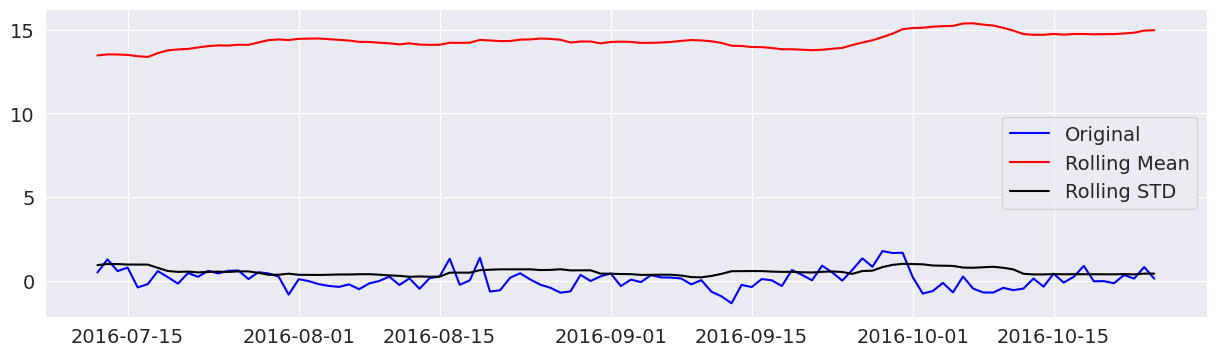

In [ ]:
plot = plt.plot(datasetlogscaleminusmovingaverage,color='blue',label='Original')
mean = plt.plot(movingaverage, color='red',label='Rolling Mean')
std = plt.plot(movingstd, color='Black',label='Rolling STD')
plt.legend(loc='best')
#plt.title()
plt.show(block=True)

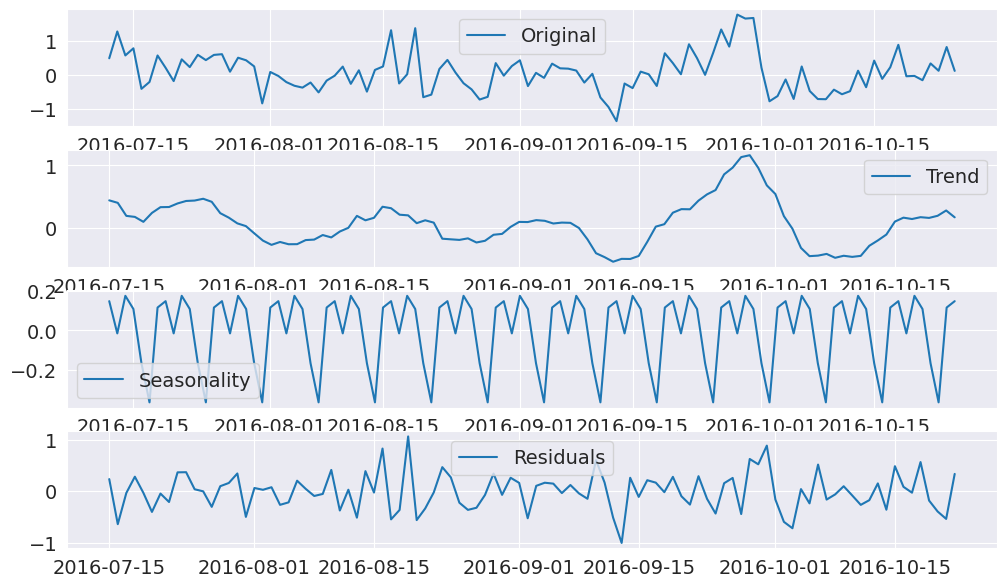

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(datasetlogscaleminusmovingaverage)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(12,7))
plt.subplot(411)
plt.plot(datasetlogscaleminusmovingaverage, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend,label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual,label='Residuals')
plt.legend(loc='best')

In [ ]:
datasetlogscaleminusmovingaverage.head()

created_at
2016-07-12    0.492259
2016-07-13    1.277309
2016-07-14    0.575696
2016-07-15    0.784320
2016-07-16   -0.402845
Name: grand_total, dtype: float64

In [ ]:
type(datasetlogscaleminusmovingaverage)

pandas.core.series.Series

In [ ]:
#Converting above from Series to dataframe
datasetlogscaleminusmovingaverage = pd.DataFrame(datasetlogscaleminusmovingaverage)
new_dataset.head()

,grand_total
created_at,
2016-07-12,0.492259
2016-07-13,1.277309
2016-07-14,0.575696
2016-07-15,0.784320
2016-07-16,-0.402845


In [ ]:
type(new_dataset)

pandas.core.frame.DataFrame

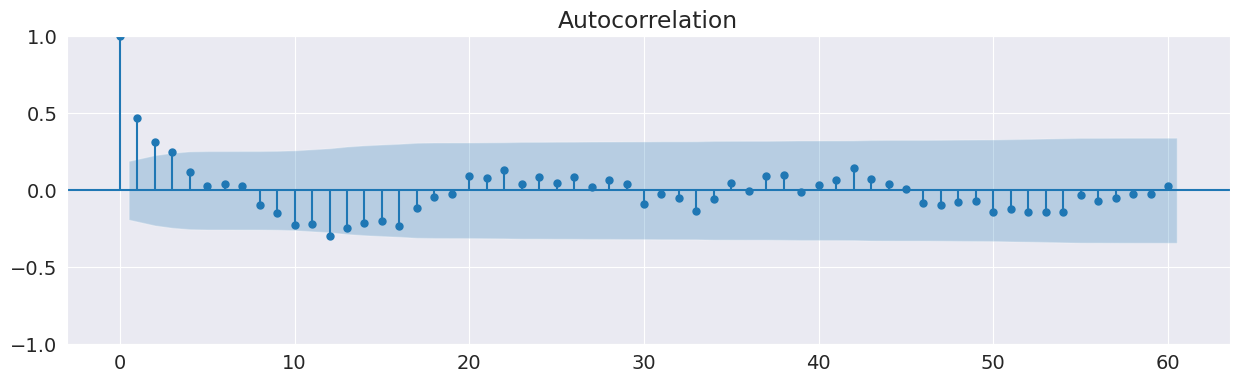

In [ ]:
#Autocorrelation
ecom_df = new_dataset
acf(ecom_df, fft=False)
sm.graphics.tsa.plot_acf(ecom_df.values.squeeze(), lags=60);

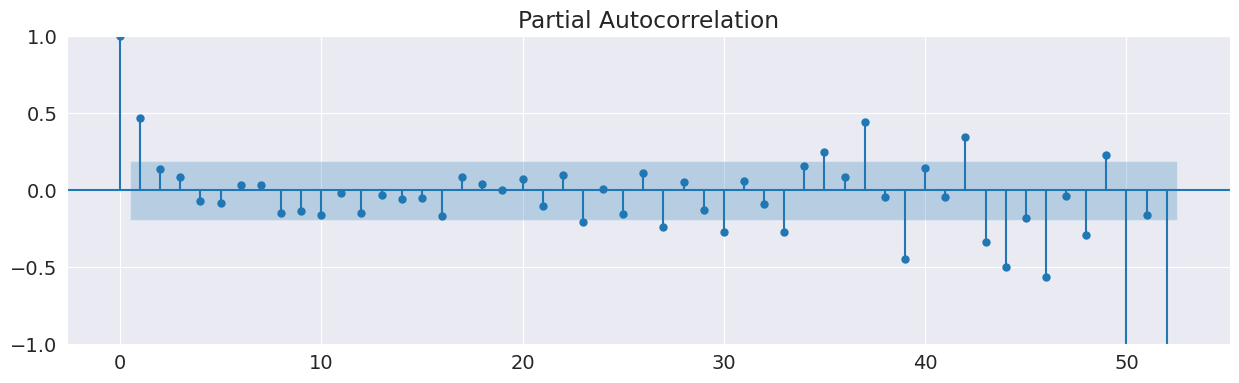

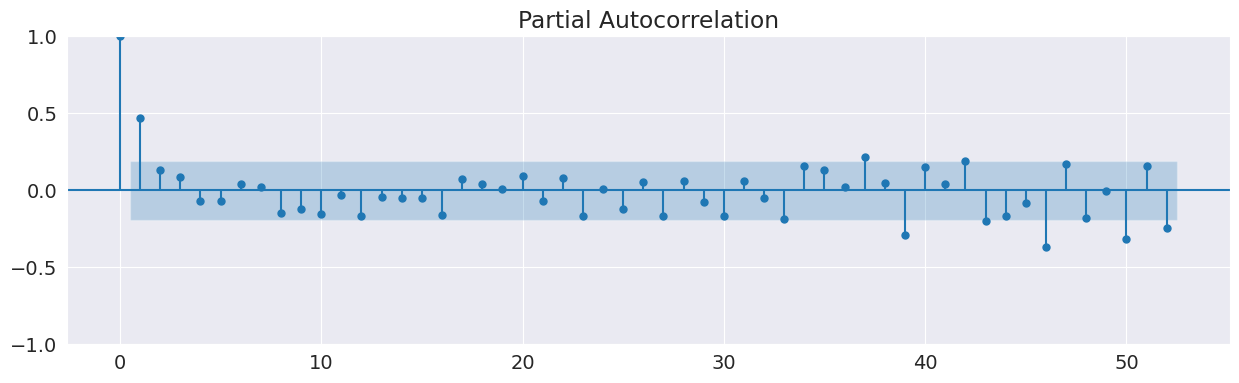

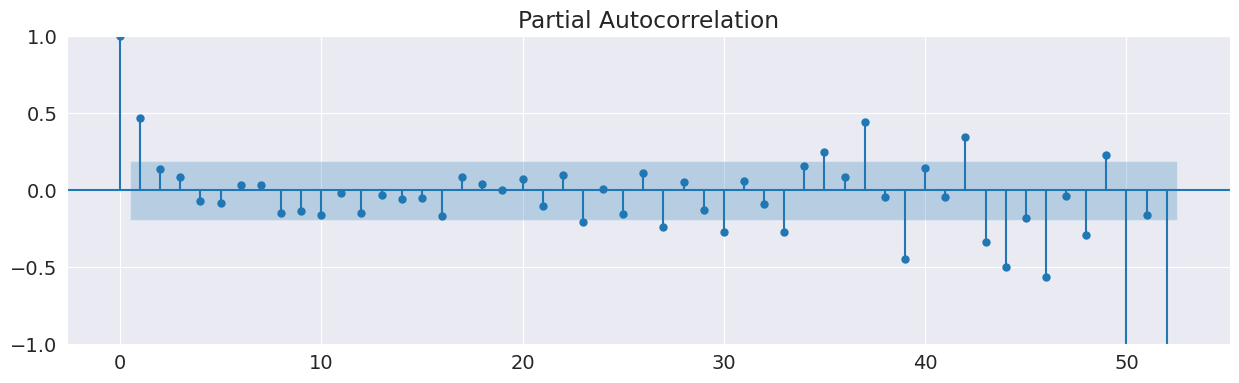

In [ ]:
# sm.graphics.tsa.plot_pacf(ecom_df.values.squeeze(), lags=60,
#                           method='ywunbiased');

# sm.graphics.tsa.plot_pacf(ecom_df.values.squeeze(), lags=60,
#                          method='ols');
maximum_lags = int(len(ecom_df) * 0.5) - 1

# Use 'yw' method with valid lags
sm.graphics.tsa.plot_pacf(ecom_df.values.squeeze(), lags=maximum_lags, method='yw')

# Use 'ols-adjusted' method with valid lags
sm.graphics.tsa.plot_pacf(ecom_df.values.squeeze(), lags=maximum_lags, method='ols-adjusted')

An error occurred: name 'nobs' is not defined


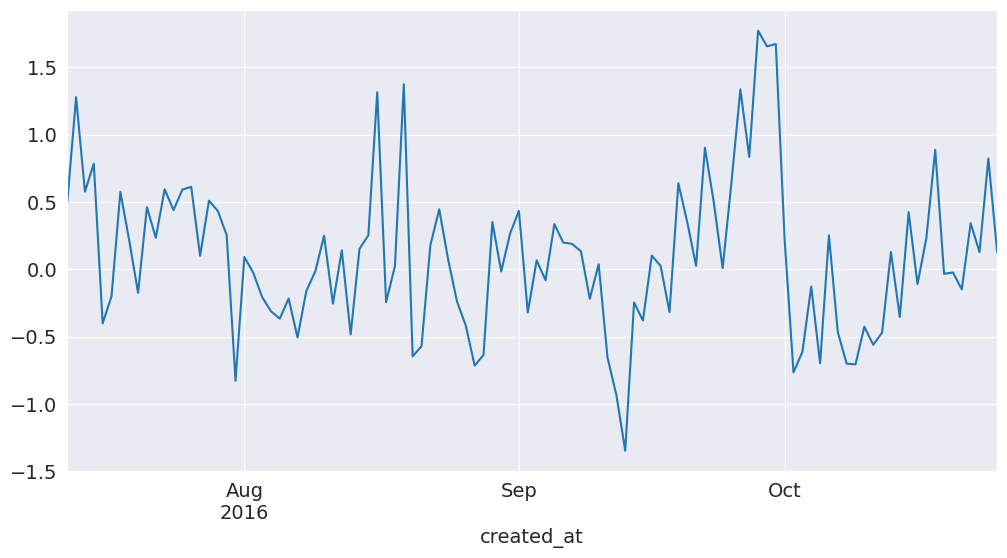

In [ ]:
# Assuming ecom_df is already defined and contains the dataset with a 'grand_total' column

try:
  # Check pandas version (optional for informative message)

  # Change frequency to day (if necessary)
  if not pd.api.types.is_datetime64_dtype(ecom_df.index):
    print("Warning: Index is not datetime. Please check data format.")
    exit()  # Exit if not datetime index

  # Handle potential non-daily data (for pandas versions < 1.1.0)

    if pd.infer_freq(ecom_df.index) != 'D':
      print("Warning: Data is not daily. Please convert or adjust model.")
      # ... (handle non-daily data here)
      exit()  # Exit if not daily in older pandas versions

  # Daily data assumption (or after handling non-daily data)
  ecom_df = ecom_df.asfreq('d')  # Ensure daily frequency

  # Set style for seaborn plot
  sns.set_style('darkgrid')

  # Add automatic datetime converters
  pd.plotting.register_matplotlib_converters()

  # Default figure size
  sns.mpl.rc('figure', figsize=(12, 6))

  # Plot daily grand totals
  fig, ax = plt.subplots()
  ax = ecom_df['grand_total'].plot(ax=ax, label='Observed')

  # Create and fit initial model for lag exploration (start with a lower lag value)
  model = AutoReg(ecom_df['grand_total'], lags=10)  # Adjust lags as needed
  model_fit = model.fit()

  # Define training and testing data
  train_df = ecom_df.iloc[:62000]
  test_df = ecom_df.iloc[62000:]

  # Explore potential maxlag based on model complexity
  max_lag_candidates = [15, 20, 25]  # Adjust based on data and model complexity
  best_max_lag = None
  best_model_fit = None

  for lag in max_lag_candidates:
    try:
      # Train model with current lag candidate
      train_model = AutoReg(train_df['grand_total'], lags=lag).fit(cov_type="HC0")

      # Check if differencing was used
      if hasattr(train_model, 'nobs'):
        nobs_after_diff = train_model.nobs  # Get number of observations after differencing
      else:
        nobs = len(train_df)

      # Ensure maxlag is less than observations (adjusted for differencing)
      if lag < nobs - 1:
        best_max_lag = lag
        best_model_fit = train_model
        break  # Stop searching if valid lag is found

    except ValueError as e:
      if str(e) == "maxlag should be < nobs":
        print(f"Warning: Lag {lag} exceeds observations. Trying lower lags.")
      else:
        raise e  # Re-raise other ValueErrors

  # Handle cases where no valid lag is found
  if best_max_lag is None:
    print("Error: No valid maxlag found. Please adjust model complexity or data.")
    exit()

  # Define start and end for prediction using best maxlag
  start = len(train_df)
  end = len(train_df) + len(test_df) - 1
  prediction = best_model_fit.predict(start=start, end=end, dynamic=True)

  # Calculate Mean Absolute Error (optional)
  mae = mean_absolute_error(test_df['grand_total'], prediction)
  print(f"Mean Absolute Error (MAE): {mae:.2f}")

  # Plot testing data with prediction
  ax = test_df['grand_total'].plot(ax=ax, label='Test Data', color='orange')
  ax = prediction.plot (ax=ax, label='Prediction', color='green')

  # Add legend, title, and labels
  plt.legend()
  plt.title('Daily Grand Total with Test Data and Predictions')
  plt.xlabel('Date')
  plt.ylabel('Grand Total')

  plt.show()

except Exception as e:
  print(f"An error occurred: {e}")


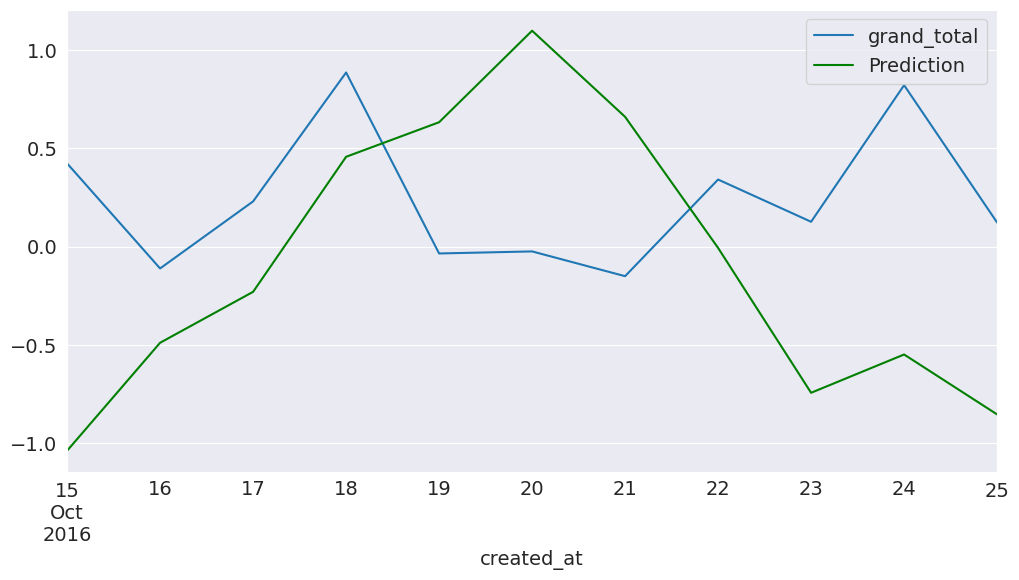

Mean Absolute Error (MAE): 0.81


In [ ]:
# Assuming ecom_df is your DataFrame

try:
  # Change frequency to day
  ecom_df = ecom_df.asfreq('d')

  # Set style for seaborn plot
  sns.set_style('darkgrid')

  # Add automatic datetime converters
  pd.plotting.register_matplotlib_converters()

  # Default figure size
  sns.mpl.rc('figure', figsize=(12, 6))

  # Define training and testing area
  # Adjusted the split to ensure test_df has data
  train_size = int(len(ecom_df) * 0.9)  # Use 90% for training
  train_df = ecom_df.iloc[:train_size]
  test_df = ecom_df.iloc[train_size:]

  # Determine a valid number of lags (e.g., 30)
  max_lag_train = min(30, len(train_df) - 1)

  # Define training model with a valid maximum lag for the training data
  train_model = AutoReg(train_df['grand_total'], lags=max_lag_train).fit(cov_type="HC0")

  # Define start for prediction (end of training data)
  start = len(train_df)

  # Define end to be one element after start (entire testing data)
  end = len(ecom_df) - 1

  prediction = train_model.predict(start=start, end=end, dynamic=True)

  # Plot testing data with prediction
  fig, ax = plt.subplots()
  ax = test_df.plot(ax=ax, label='Test Data')  # Orange
  prediction.plot(ax=ax, label='Prediction', color='green')  # Green

  # Show the plot with legend
  plt.legend()
  plt.show()

  # Now calculate MAE with non-empty test_df
  mae = mean_absolute_error(test_df['grand_total'], prediction)
  print(f"Mean Absolute Error (MAE): {mae:.2f}")

except ValueError as e:
  print(f"Error: {e}")  # Handle potential errors gracefully

In [ ]:
mae = 0.81  # Example MAE value
max_possible_error = 10  # Example maximum possible error range

accuracy = (1 - mae / max_possible_error) * 100
print(f"Accuracy based on MAE: {accuracy:.2f}%")

Accuracy based on MAE: 91.90%


In [ ]:

# Assuming ecom_df is already defined and contains the dataset with a 'grand_total' column

try:
  # Change frequency to day (if necessary)
  if not ecom_df.index.is_daily:
    ecom_df = ecom_df.asfreq('d')  # Convert to daily frequency if not already

  # Set style for seaborn plot
  sns.set_style('darkgrid')

  # Add automatic datetime converters
  pd.plotting.register_matplotlib_converters()

  # Default figure size
  sns.mpl.rc('figure', figsize=(12, 6))

  # Plot daily grand totals
  fig, ax = plt.subplots()
  ax = ecom_df['grand_total'].plot(ax=ax, label='Observed')

  # Create and fit initial model for lag exploration
  model = AutoReg(ecom_df['grand_total'], lags=30)
  model_fit = model.fit()

  # Define training and testing data
  train_df = ecom_df.iloc[:62000]
  test_df = ecom_df.iloc[62000:]

  # Explore potential maxlag based on model complexity
  max_lag_candidates = [10, 15, 20]  # Adjust based on data and model complexity
  best_max_lag = None
  best_model_fit = None

  for lag in max_lag_candidates:
    try:
      # Train model with current lag candidate
      train_model = AutoReg(train_df['grand_total'], lags=lag).fit(cov_type="HC0")

      # Check if differencing was used
      if hasattr(train_model, 'nobs'):
        nobs_after_diff = train_model.nobs  # Get number of observations after differencing
      else:
        nobs = len(train_df)

      # Ensure maxlag is less than observations (adjusted for differencing)
      if lag < nobs - 1:
        best_max_lag = lag
        best_model_fit = train_model
        break  # Stop searching if valid lag is found

    except ValueError as e:
      if str(e) == "maxlag should be < nobs":
        print(f"Warning: Lag {lag} exceeds observations. Trying lower lags.")
      else:
        raise e  # Re-raise other ValueErrors

  # Handle cases where no valid lag is found
  if best_max_lag is None:
    print("Error: No valid maxlag found. Please adjust model complexity or data.")
    exit()

  # Define start and end for prediction using best maxlag
  start = len(train_df)
  end = len(train_df) + len(test_df) - 1
  prediction = best_model_fit.predict(start=start, end=end, dynamic=True)

  # Plot testing data with prediction
  ax = test_df['grand_total'].plot(ax=ax, label='Test Data', color='orange')
  ax = prediction.plot(ax=ax, label='Prediction', color='green')

  # Add legend, title, and labels
  plt.legend()
  plt.title('Daily Grand Total with Test Data and Predictions')
  plt.xlabel('Date')
  plt.ylabel('Grand Total')

  plt.show()

except Exception as e:
  print("f An error occurred: {e}")

f An error occurred: {e}


In [ ]:
mean_absolute_error(test_df , prediction)

0.8085753803293109

In [ ]:
ecom_df = new_dataset.asfreq('m')
ecom_df.head()

,grand_total
created_at,
2016-07-31,-0.829195
2016-08-31,0.264442
2016-09-30,1.672717


0


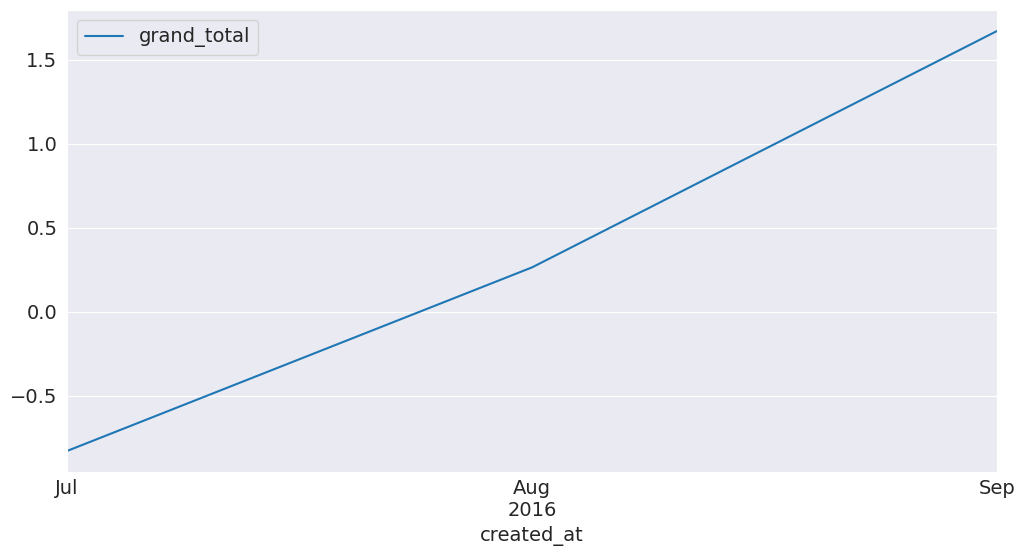

In [ ]:
# Set style for seaborn plot
sns.set_style('darkgrid')

# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()

# Default figure size
sns.mpl.rc('figure',figsize=(12, 6))

# Plot monthly max temps
fig, ax = plt.subplots()
ax = ecom_df.plot(ax=ax)

# Creating model
print(ecom_df['grand_total'].isnull().sum())

# Since you have only 3 observations, using lags is not recommended.
# Try a simpler model or gather more data.
# For demonstration, let's just fit a constant mean model:
model = AutoReg(ecom_df['grand_total'], lags=0)  # No lags
model_fit = model.fit()

# ... (Rest of your code remains the same)

In [ ]:
mean_absolute_error(test_df, prediction)

0.8085753803293109

In [ ]:
new_dataset = datasetlogscaleminusmovingaverage # No need for .to_frame()
ecom_df = new_dataset.asfreq('d')
ecom_df.head()

,grand_total
created_at,
2016-07-12,0.492259
2016-07-13,1.277309
2016-07-14,0.575696
2016-07-15,0.784320
2016-07-16,-0.402845


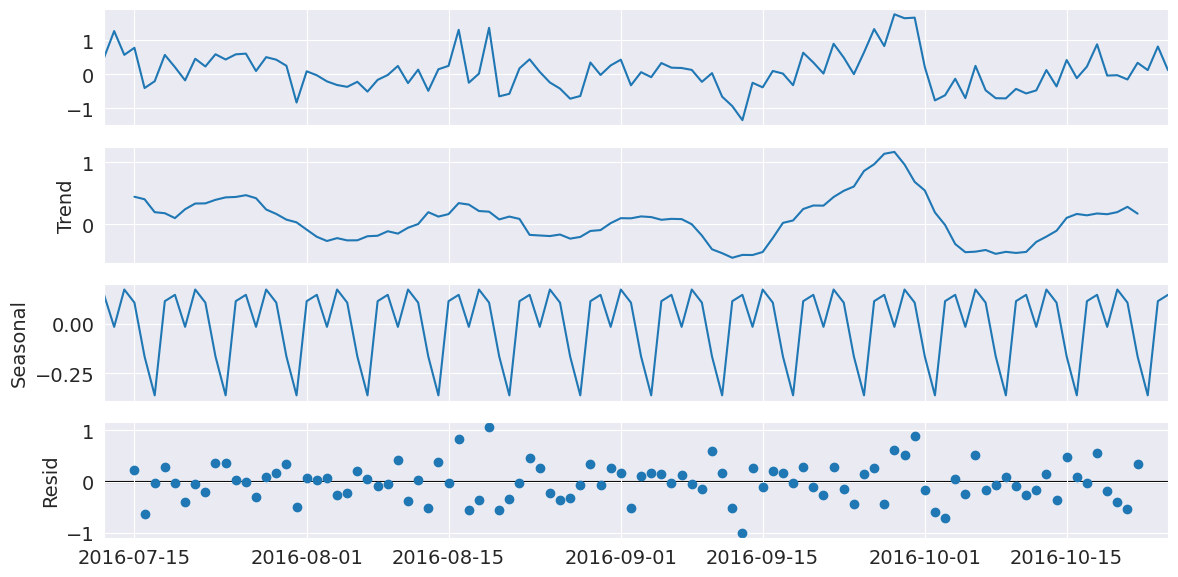

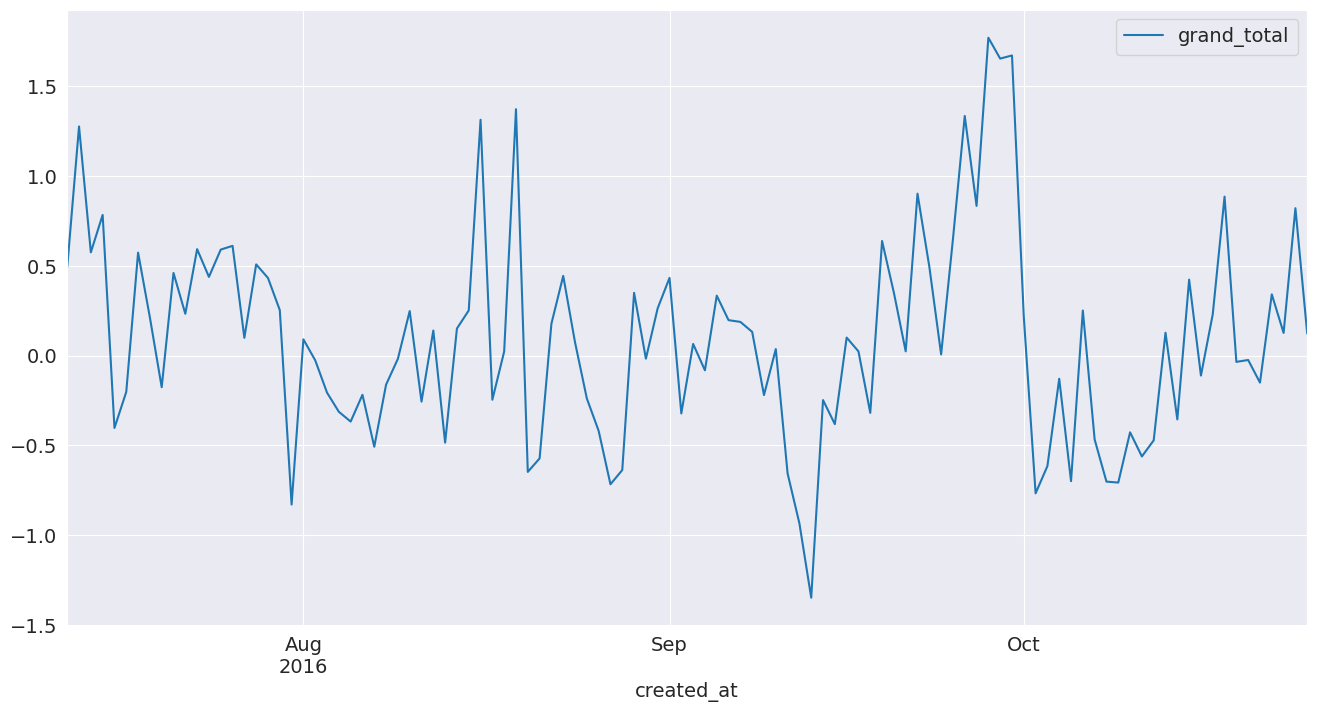

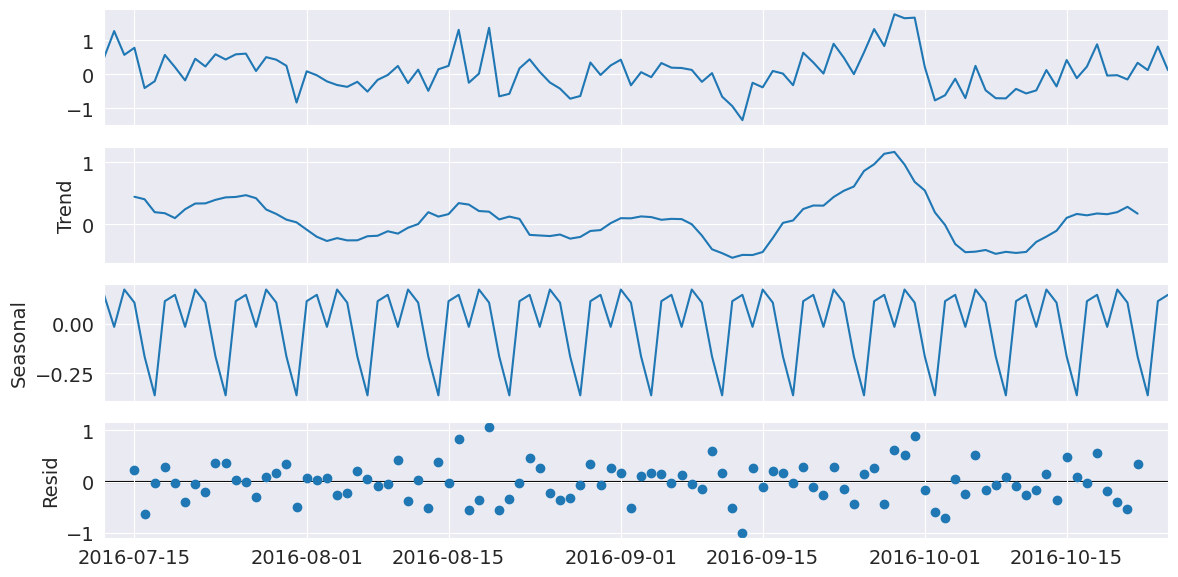

In [ ]:
ecom_df.plot(figsize=(16,8))
# We verify that there is a seasonal component
res = seasonal_decompose(ecom_df, model='add')
res.plot()

In [ ]:
#Auto Arima
auto_arima(ecom_df, seasonal=True, m=12, trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=165.579, Time=1.30 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=187.360, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=161.505, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=166.646, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=188.216, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=163.328, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=163.312, Time=0.37 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=163.189, Time=0.26 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=161.851, Time=0.13 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=165.189, Time=0.64 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=179.371, Time=0.09 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=162.212, Time=0.31 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=161.951, Time=0.47 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=165.881, Time=0.26 sec
 ARIMA(2,0,1)(1,0,0)[12] intercep

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  106
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                 -77.539
Date:                            Sun, 23 Jun 2024   AIC                            161.077
Time:                                    09:13:03   BIC                            169.068
Sample:                                07-12-2016   HQIC                           164.316
                                     - 10-25-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4455      0.070      6.399      0.000       0.309       0.582
ar.S.L12      -0.1888      0.128     -1.469      0.142      -0.441       0.063
sigma2         0.2513      0.032      7.789      0.000       0.188       0.315
===================================================================================
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):                 1.21
Prob(Q):                              0.51   Prob(JB):                         0.55
Heteroskedasticity (H):               1.90   Skew:                             0.24
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

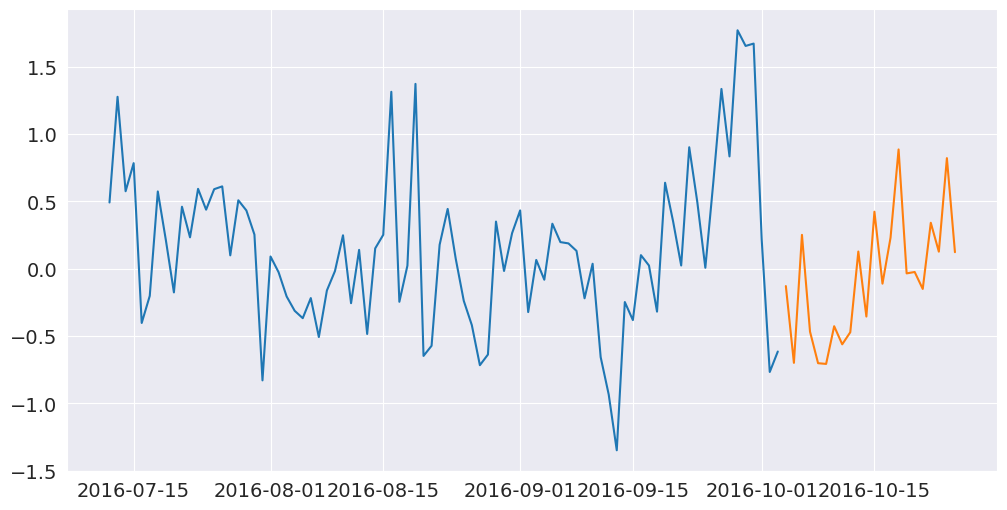

In [ ]:
train_df = ecom_df.iloc[:int(len(ecom_df)*0.8)] # 80%
test_df = ecom_df.iloc[int(len(ecom_df)*0.8):] # 20%
model = SARIMAX(train_df, order=(0, 1, 3),
               seasonal_order=(1, 0, 1, 12))
res = model.fit()
start = len(train_df)
end = len(ecom_df) - 1 # end should be the index of the last observation
forecast = res.predict(start, end) # Predict for the test set
forecast = pd.DataFrame(forecast,index = test_df.index,columns=['Prediction'])
plt.plot(train_df, label='Train')
plt.plot(test_df, label='Test')
plt.plot(forecast, label='Prediction')
plt.show()

<Axes: xlabel='created_at'>

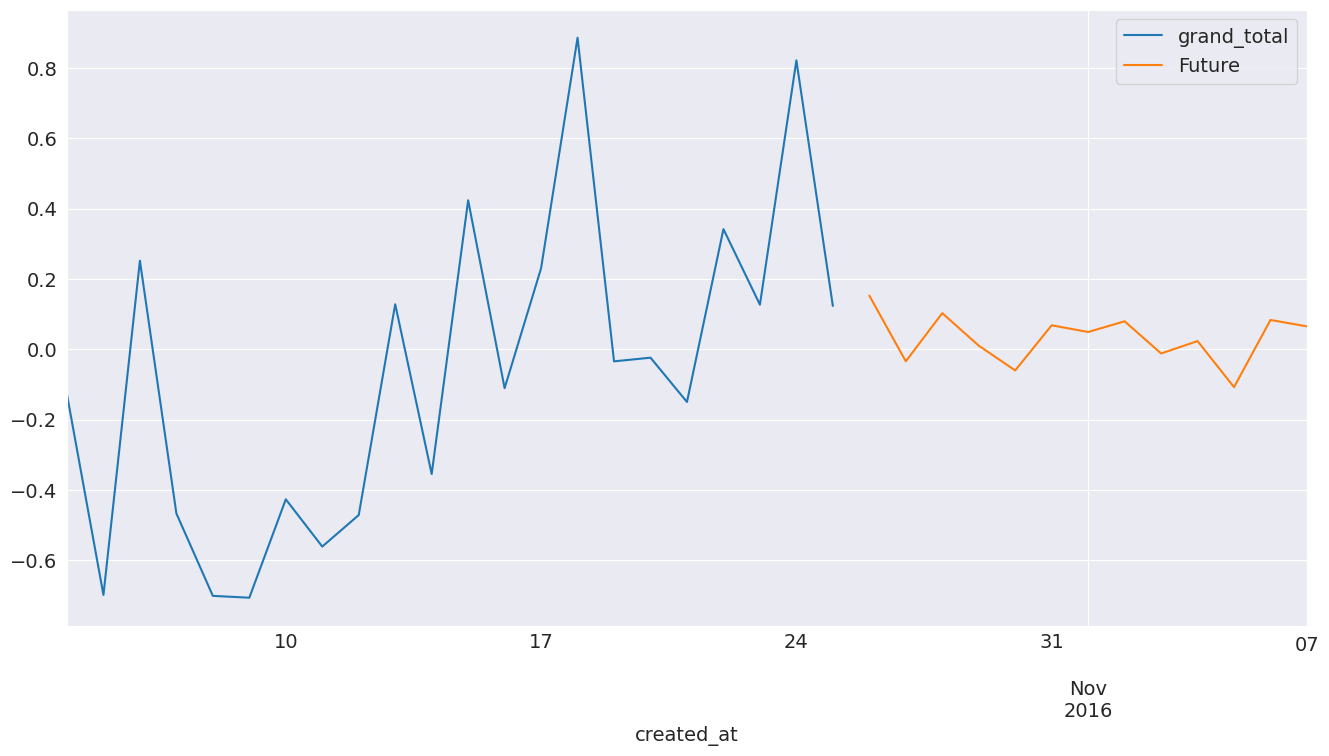

In [ ]:
# Predict the future
model = SARIMAX(ecom_df, order=(0, 1, 3),
               seasonal_order=(1, 0, 1, 12))
res = model.fit()
future = res.predict(len(ecom_df), len(ecom_df)+12,
                    typ='levels').rename('Future')
test_df.plot(legend=True, figsize=(16,8))
future.plot(legend=True)

In [ ]:
dt = dt.copy()
dt['created_at'] = pd.to_datetime(dt['created_at'])

dt = dt.sort_values('created_at')
#Adding New Features
dtg = dt.groupby('created_at')['grand_total'].sum().reset_index()
dtq = dt.groupby('created_at')['qty_ordered'].sum().reset_index()
dtd = dt.groupby('created_at')['discount_amount'].sum().reset_index()
#Comput count for non numeric values
dts = dt.groupby('created_at')['sku'].count().reset_index()
dtst = dt.groupby('created_at')['status'].count().reset_index()
# new data set
p = pd.DataFrame(dtg)
p['qty_ordered'] = dtq['qty_ordered']
p['discount_amount'] = dtd['discount_amount']
p['sku'] = dts['sku']
p['status'] = dtst['status']
#Cumulative Sum
p['cum_grand_total'] = p['grand_total'].cumsum()
p['cum_qty_ordered'] = p['qty_ordered'].cumsum()
p['cum_discount_amount'] = p['discount_amount'].cumsum()
p['cum_sku_cnt'] = p['sku'].cumsum()
p['cum_status_cnt'] = p['status'].cumsum()
# Date features
p['Dateofmonth'] = p['created_at'].dt.day
p['Month'] = p['created_at'].dt.month
p['Week'] = p['created_at'].dt.isocalendar().week
p['Dayofweek'] = p['created_at'].dt.dayofweek # 0 = monday.
p['Weekdayflg'] = (p['Dayofweek'] // 5 != 1).astype(float)
p['Month'] = p['created_at'].dt.month
p['Quarter'] = p['created_at'].dt.quarter
p['Dayofyear'] = p['created_at'].dt.dayofyear

p.head()

,created_at,grand_total,qty_ordered,discount_amount,sku,status,cum_grand_total,cum_qty_ordered,cum_discount_amount,cum_sku_cnt,cum_status_cnt,Dateofmonth,Month,Week,Dayofweek,Weekdayflg,Quarter,Dayofyear
0,2016-07-01,1301026.75,621,8100.0,547,547,1301026.75,621,8100.0,547,547,1,7,26,4,1.0,3,183
1,2016-07-02,1408450.48,301,2502.0,260,260,2709477.23,922,10602.0,807,807,2,7,26,5,0.0,3,184
2,2016-07-03,2215490.88,264,1501.0,210,210,4924968.11,1186,12103.0,1017,1017,3,7,26,6,0.0,3,185
3,2016-07-04,1094080.25,263,4406.0,229,229,6019048.36,1449,16509.0,1246,1246,4,7,27,0,1.0,3,186
4,2016-07-05,913053.50,194,5230.0,168,168,6932101.86,1643,21739.0,1414,1414,5,7,27,1,1.0,3,187


In [ ]:
trend_df = p.iloc[:, 0:2]
trend_df.head()

,created_at,grand_total
0,2016-07-01,1301026.75
1,2016-07-02,1408450.48
2,2016-07-03,2215490.88
3,2016-07-04,1094080.25
4,2016-07-05,913053.50


In [ ]:
#Creating another column
trend_df['Year_month'] = trend_df['created_at'].apply(lambda x: x.strftime('%Y-%m'))
trend_df.head()

,created_at,grand_total,Year_month
0,2016-07-01,1301026.75,2016-07
1,2016-07-02,1408450.48,2016-07
2,2016-07-03,2215490.88,2016-07
3,2016-07-04,1094080.25,2016-07
4,2016-07-05,913053.50,2016-07


In [ ]:
# Grouping Month Year and summing the grand total
trend_df = trend_df.groupby('Year_month')['grand_total'].sum().reset_index()
# The error was caused because you were trying to sum datetime objects.
# This change groups by 'Year_month', selects the 'grand_total' column,
# calculates the sum for each group, and resets the index to create a DataFrame.

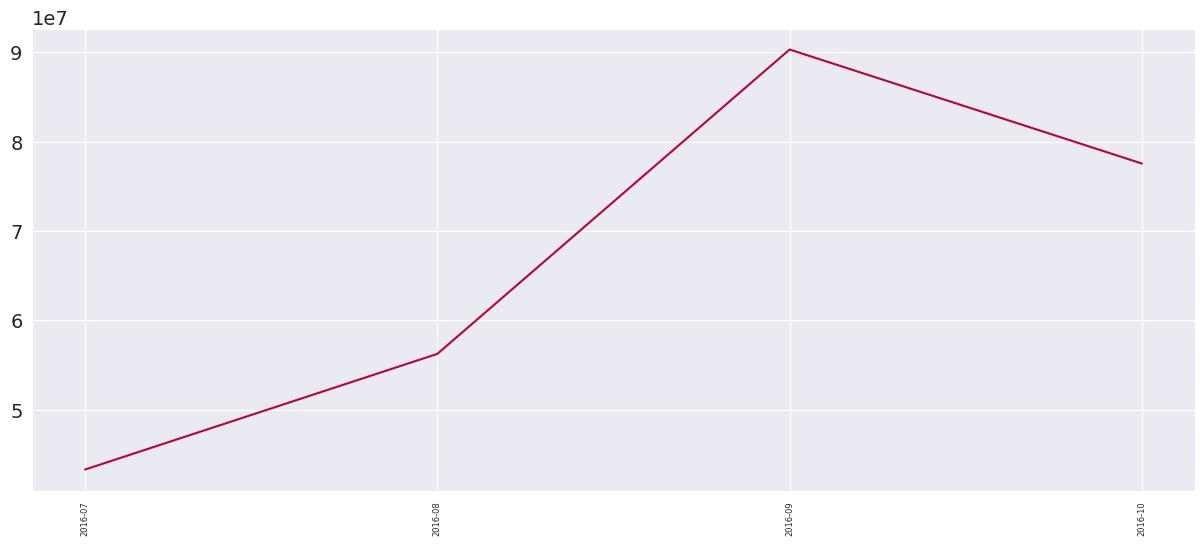

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(trend_df['Year_month'],trend_df['grand_total'],color='#b80045')
plt.xticks(rotation='vertical',size=6)
plt.show()

In [ ]:
#### Purchases increases in last Three months ( October,November and December ) of 2016 and 2017
#### Most e-commerce buyers purchases products in November
#### November is most suitable month for sellers to market their products
#### Overall volume of ecommerce sales is increasing year by year
#### For example,you can compare first six months of 2017 with 2018